In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# 날짜 변수 처리
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [4]:
# 파생 변수 생성
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.weekday

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.weekday

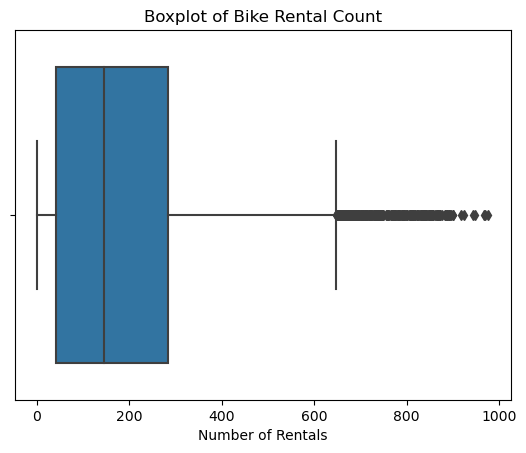

In [5]:
# boxplot으로 이상치 시각화
sns.boxplot(x=train["count"])
plt.title("Boxplot of Bike Rental Count")
plt.xlabel("Number of Rentals")
plt.show()

In [6]:
# 이상치 제거
Q1 = train['count'].quantile(0.25)
Q3 = train['count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

train = train[(train['count'] > lower_bound) & (train['count'] < upper_bound)]

In [7]:
# 종속 변수 로그 변환
y_train = np.log1p(train['count'])

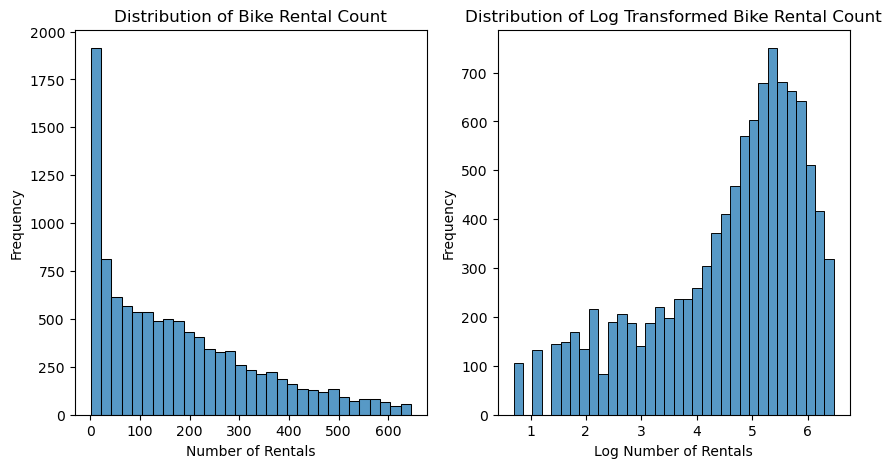

In [8]:
# 자전거 대여량 분포 시각화
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(train["count"], kde=False, ax=axs[0])
axs[0].set_title("Distribution of Bike Rental Count")
axs[0].set_xlabel("Number of Rentals")
axs[0].set_ylabel("Frequency")
sns.histplot(y_train, kde=False, ax=axs[1])
axs[1].set_title("Distribution of Log Transformed Bike Rental Count")
axs[1].set_xlabel("Log Number of Rentals")
axs[1].set_ylabel("Frequency")
plt.show()

In [9]:
# 피처 선택 및 데이터 분리
feature_columns = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'weekday']
X_train = train[feature_columns]
test = test[feature_columns]

In [10]:
# 원-핫 인코딩을 위한 함수
def one_hot_encoding(data, cols):
    for col in cols:
        dummies = pd.get_dummies(data[col], prefix=col, drop_first=False)
        data = pd.concat([data, dummies], axis=1)
    return data.drop(cols, axis=1)

# 범주형 변수를 원-핫 인코딩으로 변환
categorical_columns = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'day', 'hour', 'weekday']
all_data = pd.concat([X_train, test], axis=0)
all_data_encoded = one_hot_encoding(all_data, categorical_columns)
X_train_encoded = all_data_encoded.iloc[:len(X_train), :]
test_encoded = all_data_encoded.iloc[len(X_train):, :]

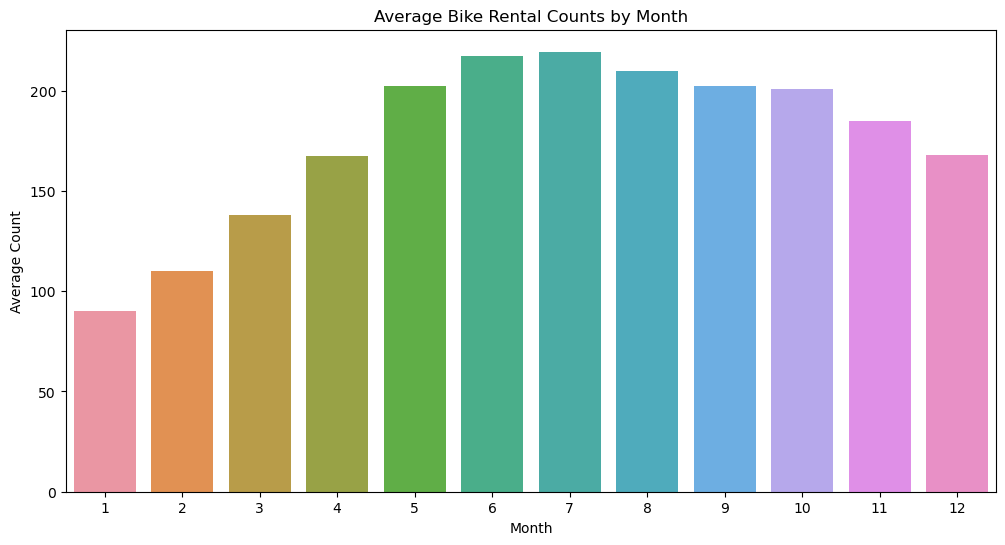

In [11]:
# 월별 자전거 대여 횟수 시각화
plt.figure(figsize=(12, 6))
monthly_counts = train.groupby('month')['count'].mean()
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Average Bike Rental Counts by Month')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.show()

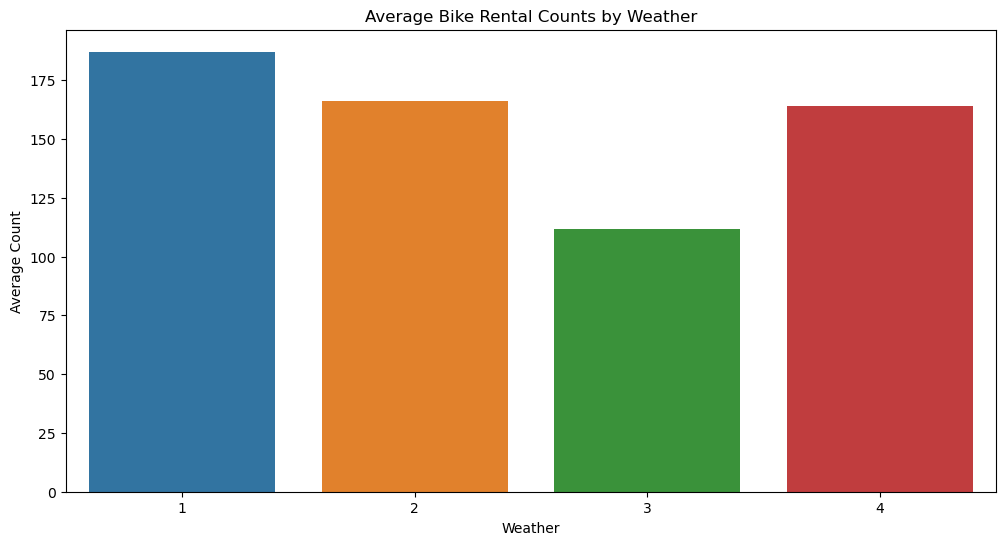

In [12]:
# 날씨별 자전거 대여 횟수 시각화
plt.figure(figsize=(12, 6))
weather_counts = train.groupby('weather')['count'].mean()
sns.barplot(x=weather_counts.index, y=weather_counts.values)
plt.title('Average Bike Rental Counts by Weather')
plt.xlabel('Weather')
plt.ylabel('Average Count')
plt.show()

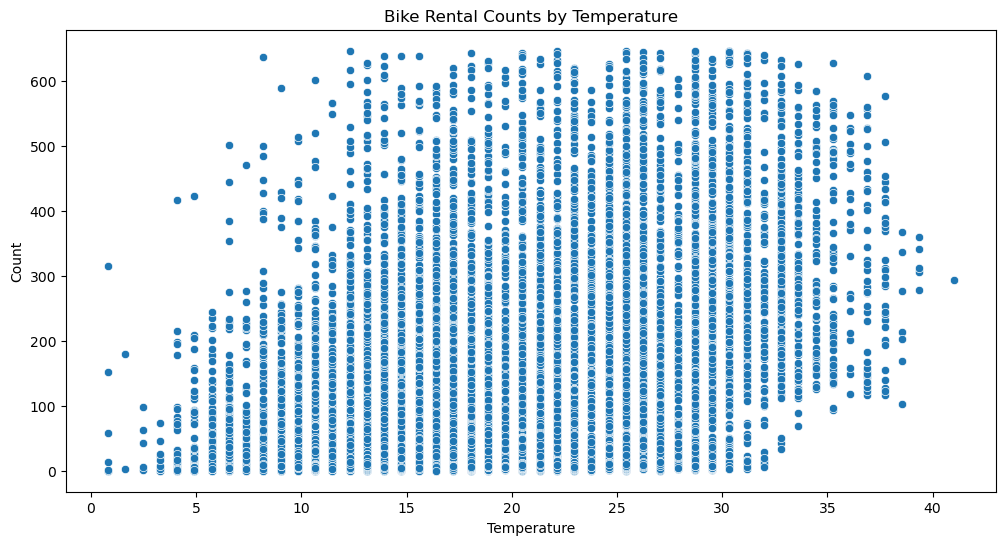

In [13]:
# 온도별 자전거 대여 횟수 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temp', y='count', data=train)
plt.title('Bike Rental Counts by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()

In [14]:
# 학습 데이터셋과 검증 데이터셋 분리
X_train_split, X_valid_split, y_train_split, y_valid_split = train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

In [15]:
# XGBoost 모델
xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train_split, y_train_split, early_stopping_rounds=10, eval_set=[(X_valid_split, y_valid_split)], eval_metric='rmsle', verbose=False)

C:\Users\dhj98\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\dhj98\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

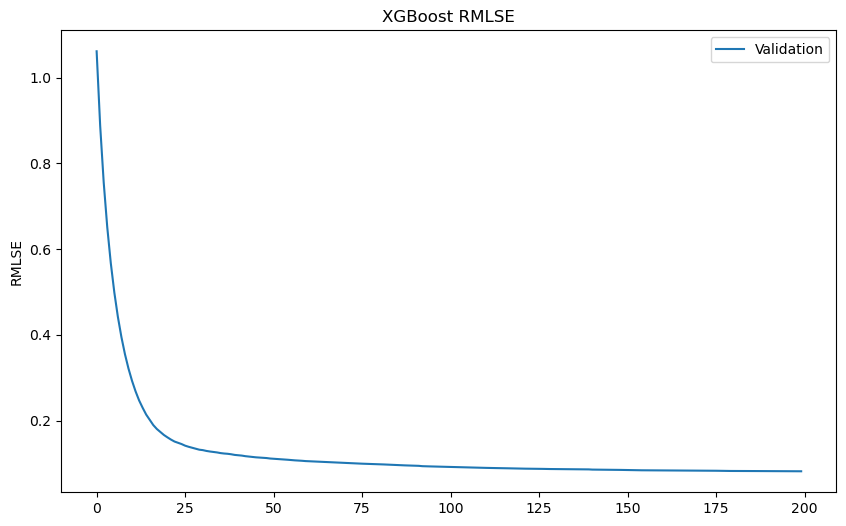

In [16]:
# 검증 데이터셋에서의 성능 변화 시각화
results = xgb.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['rmsle'], label='Validation')
ax.legend()
plt.ylabel('RMLSE')
plt.title('XGBoost RMLSE')
plt.show()

In [17]:
# LightGBM 모델
lgbm = LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
lgbm.fit(X_train_split, y_train_split, early_stopping_rounds=10, eval_set=[(X_valid_split, y_valid_split)], eval_metric='root_mean_squared_log_error', verbose=False)

C:\Users\dhj98\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\dhj98\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMRegressor(max_depth=5, n_estimators=200, random_state=42)

In [18]:
# 예측
xgb_predictions = np.expm1(xgb.predict(test_encoded))
lgbm_predictions = np.expm1(lgbm.predict(test_encoded))

In [19]:
# 앙상블
ensemble_predictions = (xgb_predictions + lgbm_predictions) / 2

In [20]:
# 결과 저장
submission = pd.read_csv('sampleSubmission.csv')
submission['count'] = ensemble_predictions
submission.to_csv('submission.csv', index=False)